In [80]:
# Importing Pyspark

import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-3.1.2-bin-hadoop3.2'

In [81]:
# Loading Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark_Basics").getOrCreate()
from pyspark.sql.functions import approxCountDistinct, countDistinct, count, when, isnan, col, isnull

#

In [82]:
# Question 1
# Loading in the data

df = pd.read_csv("cruise_ship_info_missing.csv")

# print(df.head(5))
# Bottom line is to check and see if the data actually loaded (for possible errors)

In [83]:
# Question 1
# Performing Basic Statistics on the dataset

print(df.describe())

# Based on this data we can infer several different notes. Like in the first column we can see the average person- 
# - riding one of these cruise ship is below the age of 22, etc. An important take away is that there are not -
# enough data points in each catagory so we need to fill those in.

df = df.replace(' ', np.nan)

              Age     Tonnage  passengers      length      cabins  \
count  153.000000  156.000000  156.000000  156.000000  157.000000   
mean    15.699346   70.906910   18.511346    8.111474    8.819363   
std      7.706017   37.291292    9.628711    1.796905    4.483720   
min      4.000000    2.329000    0.660000    2.790000    0.330000   
25%     10.000000   45.750000   12.605000    7.087500    6.070000   
50%     14.000000   70.486500   19.500000    8.550000    9.500000   
75%     20.000000   90.317500   24.515000    9.510000   10.940000   
max     48.000000  220.000000   54.000000   11.820000   27.000000   

       passenger_density        crew  
count         154.000000  154.000000  
mean           39.917338    7.825390  
std             8.687939    3.493538  
min            17.700000    0.590000  
25%            34.570000    5.480000  
50%            38.940000    8.150000  
75%            44.185000    9.997500  
max            71.430000   21.000000  


<AxesSubplot:>

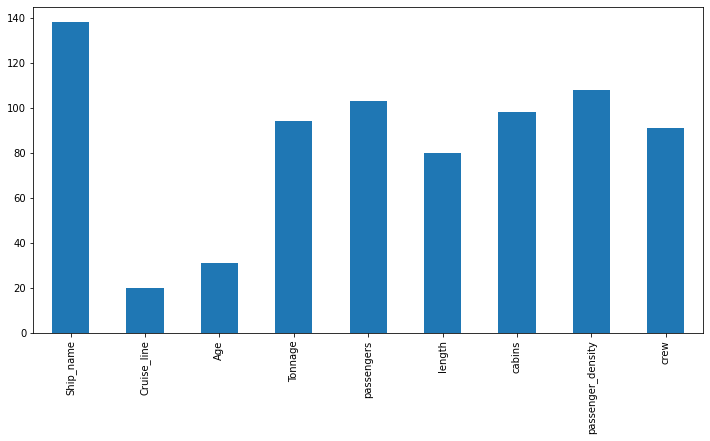

In [84]:
# Question 2
# Cardinality of each Variable

df.nunique().plot.bar(figsize=(12,6))

# The cardinality (the amount of unique elements in the variable) is an acceptable amount for all variables 
# (in this case above 1) which means no variable gets disqualified based on this alone.

In [85]:
# Question 3
# Percentage of Missing Values

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing' : percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
print(missing_value_df)

# Based off of my results, I should not delete any variables for missing too much data

                   percent_missing
Ship_name                 0.000000
cabins                    0.632911
Tonnage                   1.265823
passengers                1.265823
length                    1.265823
passenger_density         2.531646
crew                      2.531646
Age                       3.164557
Cruise_line               3.797468


In [86]:
# Question 1 Pyspark Version
# Importing the Data to Pyspark

file_location = "cruise_ship_info_missing.csv"
file_type = "csv"
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type)\
.option("InferSchema", infer_schema)\
.option("header", first_row_is_header)\
.option("sep", delimiter)\
.load(file_location)

# df.show(15)
# Testing

In [87]:
# Question 1 Pyspark Version
# Basic Statistical Analysis


columns = len(df.columns)
print(f'Number of Columns: {columns}')

print('\nData Types from Schema:')
df.printSchema()

df.describe().toPandas()


# This table shows Mean, Min, Max, Count, and StdDev.

Number of Columns: 9

Data Types from Schema:
root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



,summary,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,count,158,152,153,156,156,156,157,154,154
1,mean,Infinity,None,15.699346405228757,70.9069102564103,18.51134615384616,8.111474358974359,8.819363057324846,39.91733766233766,7.825389610389613
2,stddev,None,None,7.70601693084206,37.29129191896472,9.628710903337458,1.7969047956137207,4.483719935890096,8.687938528337261,3.4935378500821637
3,min,Adventure,Azamara,4,2.329,0.66,2.79,0.33,17.7,0.59
4,max,Zuiderdam,Windstar,48,220.0,54.0,11.82,27.0,71.43,21.0


In [88]:
# Question 2 in Pyspark
#

def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[approxCountDistinct(c).alias(c) for c in df.columns])
    
    ## convert to pandas for efficient calculations
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True) 
    final_cardinality_df.rename(columns={0:'Cardinality'}, inplace=True) 
    
    vars_selected = final_cardinality_df['index'][final_cardinality_df['Cardinality'] <= cut_off] 
    
    return final_cardinality_df, vars_selected

cardinality_df, cardinality_vars_selected = cardinality_calculation(df)
cardinality_df

# Based off these results, all the the columns should be kept since all have more than 1 unique variable.

,index,Cardinality
0,Ship_name,142
1,Cruise_line,20
2,Age,32
3,Tonnage,94
4,passengers,106
5,length,80
6,cabins,103
7,passenger_density,111
8,crew,97


In [89]:
# Question 3 
#

def missing_calculation(df, miss_percentage=0.45):
    
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()

    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True) 
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True) 
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df
    
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage] 
    
    return final_missing_df, vars_selected

missing_df, missing_vars_selected = missing_calculation(df)
missing_df

# No value has missing percentage larger than 10% so we can keep all the variables.

,index,missing_count,missing_percentage
0,Ship_name,0,0.000000
1,Cruise_line,6,0.037975
2,Age,5,0.031646
3,Tonnage,2,0.012658
4,passengers,2,0.012658
5,length,2,0.012658
6,cabins,1,0.006329
7,passenger_density,4,0.025316
8,crew,4,0.025316


In [193]:
# Question 4 

pandas_df = df.toPandas()
new_pandas_df = pandas_df.drop(['Ship_name', 'Cruise_line'],axis=1)
new_df = spark.createDataFrame(new_pandas_df)

for i in new_df.columns:
    median_column = df.approxQuantile(i,[0.5],0.1)
    df = df.fillna({i :median_column[0]})
    df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in [i]]).show()


# See the results below

+---+
|Age|
+---+
|  0|
+---+

+-------+
|Tonnage|
+-------+
|      0|
+-------+

+----------+
|passengers|
+----------+
|         0|
+----------+

+------+
|length|
+------+
|     0|
+------+

+------+
|cabins|
+------+
|     0|
+------+

+-----------------+
|passenger_density|
+-----------------+
|                0|
+-----------------+

+----+
|crew|
+----+
|   0|
+----+



In [204]:
# Question 5 
# 

new_df1 = new_df.toPandas()
new_pandas_df1 = pandas_df.drop(['Age','Tonnage','passengers','length','cabins','passenger_density','crew'], axis = 1)

df1 = new_pandas_df1.ffill(axis = 0)
df2 = pd.concat([new_df1,df1], axis = 1)
new_df3 = spark.createDataFrame(df2)

print(df2['Cruise_line'].tolist())

print(df2)
print(new_df3)

['Azamara', 'Azamara', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Carnival', 'Celebrity', 'Celebrity', 'Celebrity', 'Celebrity', 'Celebrity', 'Celebrity', 'Celebrity', 'Celebrity', 'Celebrity', 'Celebrity', 'Costa', 'Costa', 'Costa', 'Costa', 'Costa', 'Costa', 'Costa', 'Costa', 'Costa', 'Costa', 'Costa', 'Crystal', 'Crystal', 'Cunard', 'Cunard', 'Cunard', 'Disney', 'Disney', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'Holland_American', 'MSC', 'MSC', 'MSC', 'MSC', 'MSC', 'MSC', 'MSC', 'MSC', 'Norwegian', 'Norwegian', 'Norwegian', 'Norwegian', 'Norwegian', 'Norwegian'

In [201]:
# Checking Question 4 and Question 5
#

def missing_calculation(new_df3, miss_percentage=0.45):
    
    missing = new_df3.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = new_df3.count()

    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True) 
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True) 
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df
    
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage] 
    
    return final_missing_df, vars_selected

missing_df, missing_vars_selected = missing_calculation(df)
missing_df

# I have no idea why this is not showing the new missing percentage for the Cruise Line; however, it seems
# to work in the code above.

,index,missing_count,missing_percentage
0,Ship_name,0,0.000000
1,Cruise_line,6,0.037975
2,Age,0,0.000000
3,Tonnage,0,0.000000
4,passengers,0,0.000000
5,length,0,0.000000
6,cabins,0,0.000000
7,passenger_density,0,0.000000
8,crew,0,0.000000


In [ ]:
spark.stop()